# WSI - laboratorium 6

Zadanie: Uczenie (się) ze wzmocnieniem

Autor: Jakub Mazurkiewicz (300226)

## Klasy pomocnicze

### Zestaw hiperparametrów

Poniższa klasa reprezentuje zestaw hiperparametrów:

In [11]:
from dataclasses import dataclass

@dataclass
class Hyperparameters:
    learning_rate: float = 0.5
    discount_factor: float = 0.6
    epsilon: float = 0.1
    episodes: int = 10000

    def __repr__(self):
        return '\n'.join([
            f'Learning rate: {self.learning_rate}',
            f'Discount factor: {self.discount_factor}',
            f'Epsilon: {self.epsilon}',
            f'Episodes: {self.episodes}'
        ])

### Statystyki z pojedynczego epizodu

Poniższa klasa reprezentuje statystyki z pojedynczego epizodu:

In [12]:
@dataclass
class EpisodesStats:
    penalty_count: int = 0
    total_reward: int = 0

### Wyniki ewaluacji

Poniższa klasa reprezentuje wyniki ewaluacji:

In [13]:
from typing import List

@dataclass
class EvaluationResult:
    avg_epoch_count: float
    avg_penalty: float
    learning_episodes: int
    stats: List[EpisodesStats]

    def __repr__(self):
        return '\n'.join([
            f'After {self.learning_episodes} episodes:',
            f'* Average epochs per episode: {self.avg_epoch_count}',
            f'* Average penalty per episode: {self.avg_penalty}'
        ])

## Klasa implementująca algorytmu Q-learning

### Schemat nagradzania

Schemat nagradzania jest taki sam jak w bibliotece `gym`:

* -1 za każdy krok (w kodzie: `epoch`), który nie kończy się wyższą nagrodą,
* +20 za pomyślny przejaz z pasażerem,
* -10 za wykonanie operacji "pickup" lub "dropoff" w niedozwolonymi miejscu.


### Kod

Poniższa klasa implementuje algorytm Q-learning:

In [14]:
import random
from typing import Tuple
import numpy as np
from gym import Env

class QLearning:
    def __init__(self, environment: Env, hyperparameters: Hyperparameters):
        self.env = environment
        self.params = hyperparameters
        self.qtable = np.zeros((self.env.observation_space.n, self.env.action_space.n))
        self.total_learning_episodes = 0

    def learn(self, seed=None) -> Tuple[List[EpisodesStats], List[EvaluationResult]]:
        learning_stats = []
        evaluation_stats = []
        stop_point_for_evaluation = self.params.episodes // 4

        for episode in range(self.params.episodes):
            state = self.env.reset() if seed is None else self.env.reset(seed=random.getrandbits(64))
            stats = EpisodesStats()
            done = False

            while not done:
                action = self._epsilon_greedy_exploration(state)
                next_state, reward, done, _ = self.env.step(action)
                self.qtable[state, action] = self.qtable[state, action] + self.params.learning_rate * (
                    reward + self.params.discount_factor * np.max(self.qtable[next_state]) - self.qtable[state, action])
                state = next_state
                stats.total_reward += reward
                stats.penalty_count += 1 if reward < 0 else 0
            learning_stats += [stats]

            if (episode + 1) % stop_point_for_evaluation == 0:
                evaluation_stats += [self.evaluate()]
            self.total_learning_episodes += 1
        return learning_stats, evaluation_stats

    def _epsilon_greedy_exploration(self, state):
        if np.random.random() < self.params.epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.qtable[state])

    def evaluate(self, seed=None) -> EvaluationResult:
        total_epochs = 0
        total_penalties = 0
        stat_list = []

        for _ in range(self.params.episodes):
            state = self.env.reset() if seed is None else self.env.reset(seed=random.getrandbits(64))
            stats = EpisodesStats()
            epochs = 0
            reward = 0
            done = False

            while not done:
                action = np.argmax(self.qtable[state])
                state, reward, done, _ = self.env.step(action)
                epochs += 1
                total_penalties += 1 if reward < 0 else 0
                stats.total_reward += reward
                stats.penalty_count += 1 if reward < 0 else 0

            total_epochs += epochs
            stat_list += [stats]

        return EvaluationResult(
            avg_epoch_count=(total_epochs / self.params.episodes),
            avg_penalty=(total_penalties / self.params.episodes),
            learning_episodes=self.total_learning_episodes,
            stats=stat_list
        )

    def save_qtable(self, filename):
        np.savetxt(filename, self.qtable)

### Dodatkowe informacje

* W trakcie uczenia 4 razy jest dokonywana ewaluacja
* Wykorzystywana jest strategia ϵ-zachłanna (funkcja `QLearning._epsilon_greedy_exploration`)

## Eksperymenty

### Funkcja do rysowania wykresów

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

def make_stats_plot(stats: List[EpisodesStats], major_title: str):
    episodes = len(stats)
    fig, axes= plt.subplots(1, 2, dpi=100)
    fig.suptitle(major_title)
    axes[0].scatter(range(1, episodes + 1), [stat.penalty_count for stat in stats], s=3)
    axes[0].set_xlabel('Number of episodes')
    axes[0].set_ylabel('Penalty count')
    axes[0].set_title('Penalties per episode')
    axes[0].grid(True)
    axes[1].scatter(range(1, episodes + 1), [stat.total_reward for stat in stats], s=3)
    axes[1].set_xlabel('Number of episodes')
    axes[1].yaxis.set_label_position('right')
    axes[1].yaxis.tick_right()
    axes[1].set_ylabel('Sum of rewards')
    axes[1].set_title('Sum of rewards per episode')
    axes[1].grid(True)

### Funkcja wspomagająca przeprowadzanie eksperymentów

In [44]:
import gym
import numpy as np
import pandas as pd

def experiment(learning_rate: float, discount_factor: float, epsilon: float, episodes: int):
    env = gym.make("Taxi-v3")
    algo = QLearning(env, Hyperparameters(learning_rate, discount_factor, epsilon, episodes))
    learning_stats, evaluation_stats = algo.learn()
    make_stats_plot(learning_stats, 'Learning process')
    for stat in evaluation_stats:
        episode = stat.learning_episodes + 1
        make_stats_plot(stat.stats, f'Evaluation while learning (after {episode} episodes of learning)')

    episodes = [f'After episode {stats.learning_episodes + 1}' for stats in evaluation_stats]
    avg_epoch_count = [stats.avg_epoch_count for stats in evaluation_stats]
    avg_penalty = [stats.avg_penalty for stats in evaluation_stats]
    summary = np.transpose([episodes, avg_epoch_count, avg_penalty])
    print(pd.DataFrame(summary, columns=['Episode', 'Average epochs per episode', 'Average penalty per episode']))
    plt.show()

### Metoda przeprowadzania eksperymentów

* Każdy eksperyment polega na zmianie jednego z hiperparametrów, tak aby uzyskać lepszy wynik niż wcześniej,
* W trakcie eksperymentu tworzona jest tabla przedstawiająca wyniki ewaluacji po `n` epizodach. Tabela jest tworzona dokładnie 4 razy i zawiera:
  - Średnią ilość epok na epizod ("epoka" to pojedyncza akcja wykonana przez algorytm),
  - Średnią ilość kar na epizod ("lara" to sytuacja, w której nagroda jest mniejsza od zera).
* W każdym eksperymencie jest tworzonych 5 wykresów:
  - Pierwszy przedstawia ilość kar i sumę nagród w zależności od epizodu w trakcie uczenia,
  - Kolejne cztery wykresy demonstrują wynik ewaluacji wykonanej w trakcie przerwy w nauczaniu. ilość kar i sumę nagród w zależności od epizodu w trakcie uczenia.

### Eksperyment 1 - wstępnie dobrane hiperparametry

Wstępnie dobrane hiperparametry:

* `learning_rate` (beta): 0.5
* `discount_factor` (gamma): 0.6
* `epsilon`: 0.1
* `episodes`: 10000 (parametr ten oznacza ilość epizodów wykorzystywanych przy nauczaniu i ewaluacji)

               Episode Average epochs per episode Average penalty per episode
0   After episode 2500                    21.5477                     20.5938
1   After episode 5000                    14.0643                     13.0697
2   After episode 7500                     13.094                      12.094
3  After episode 10000                    13.5945                     12.5975


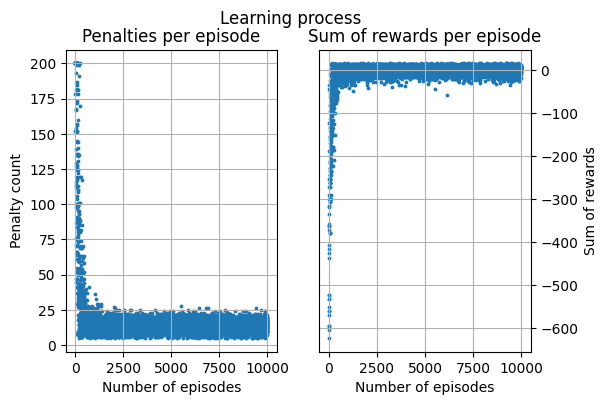

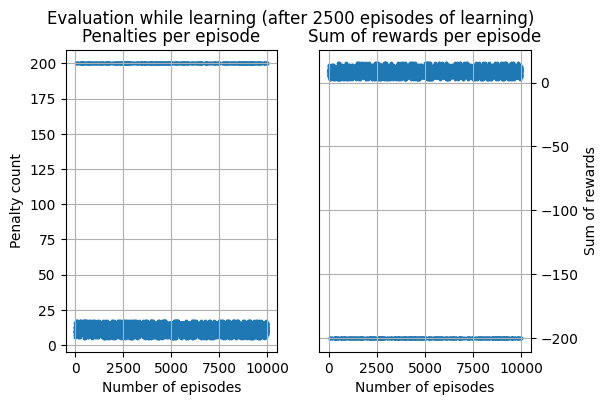

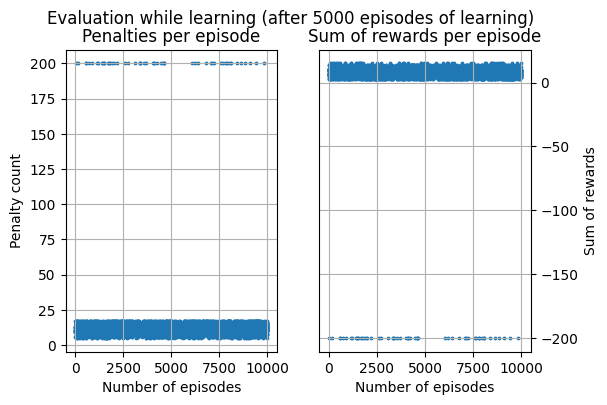

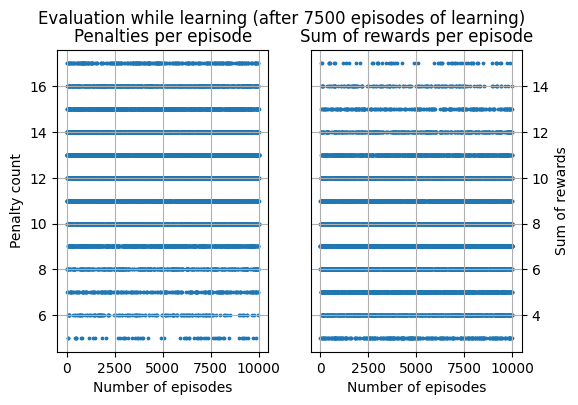

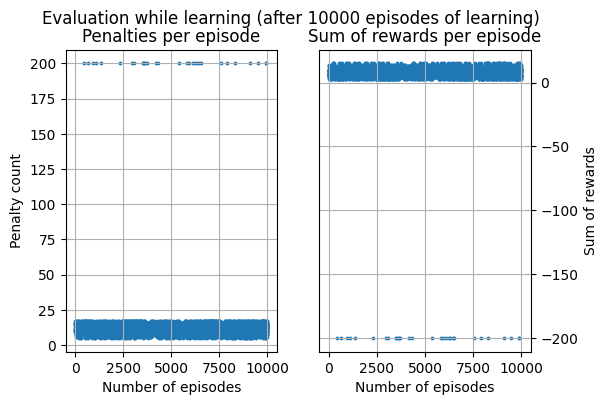

In [45]:
experiment(learning_rate=0.5, discount_factor=0.6, epsilon=0.1, episodes=10000)

### Eksperyment 2 - zwiększenie parametru `learning_rate`

W tym eksperymencie parametr `learning_rate` został zwiększony z 0.5 do 3.0

               Episode Average epochs per episode Average penalty per episode
0   After episode 2500                      200.0                       200.0
1   After episode 5000                      200.0                       200.0
2   After episode 7500                      200.0                       200.0
3  After episode 10000                      200.0                       200.0


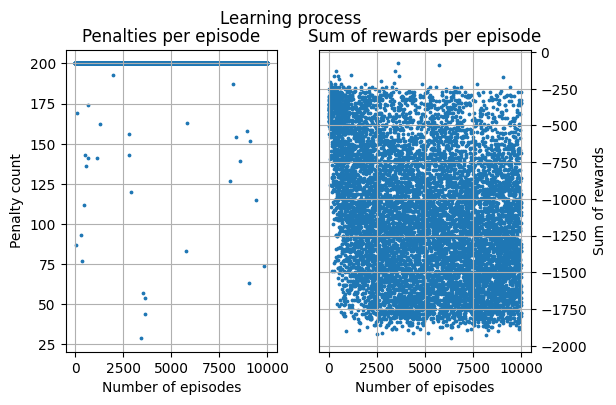

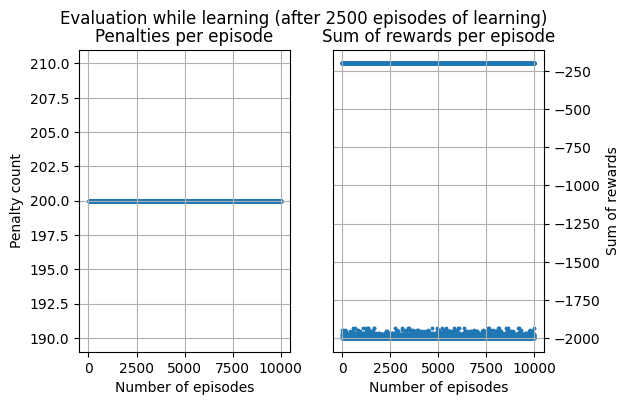

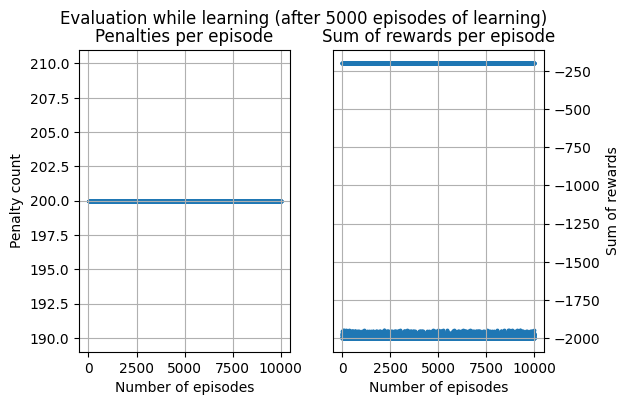

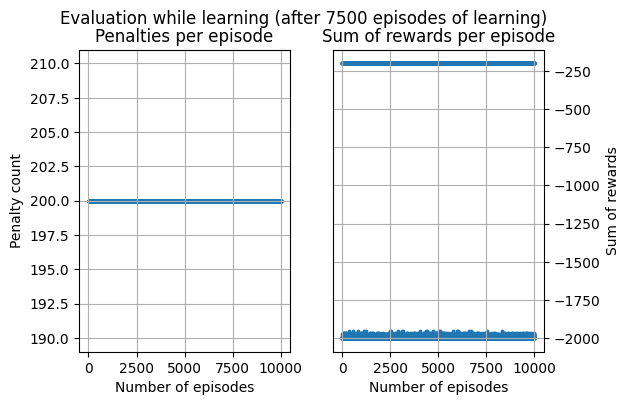

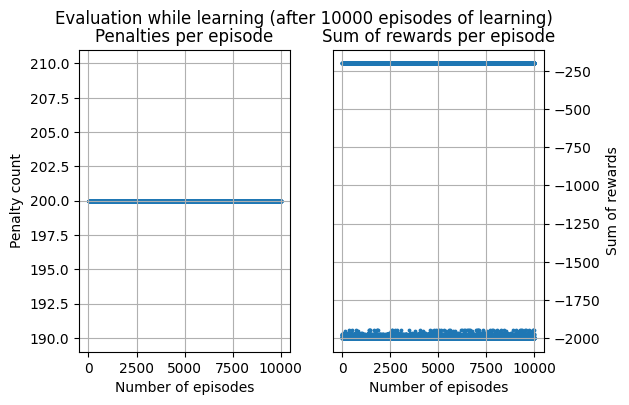

In [46]:
experiment(learning_rate=3.0, discount_factor=0.6, epsilon=0.1, episodes=10000)

Wniosek: zwiększenie wartości `learning_rate` do 3.0 wpłynęło bardzo negatywnie na wyniki:
 
* Proces uczenia znacznie się wydłużył (o kilka minut),
* Model niczego się nie nauczył - średnia ilość kar na epizod wynosiła 200 w każdej ewaluacji.

### Eksperyment 3 - zmniejszenie parametru `learning_rate`

W tym eksperymencie hiperparametr `learning_rate` został zmniejszony z 0.5 do 0.1.

               Episode Average epochs per episode Average penalty per episode
0   After episode 2500                   100.7833                    100.2568
1   After episode 5000                    72.4349                     71.7557
2   After episode 7500                    37.3195                     36.4506
3  After episode 10000                    28.7064                      27.791


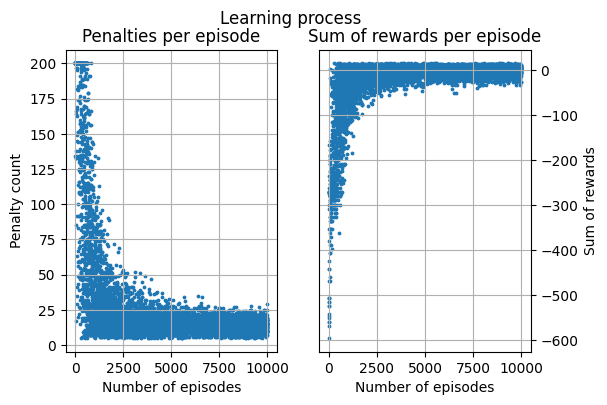

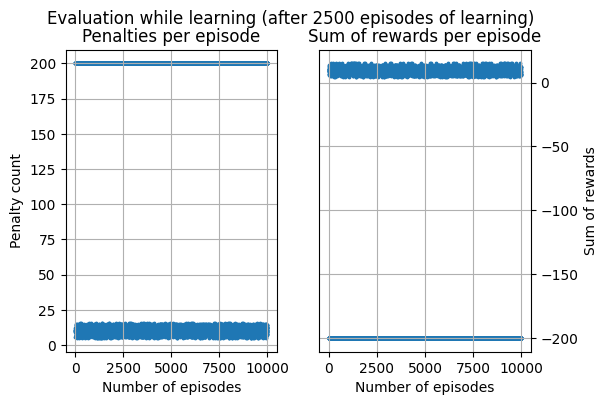

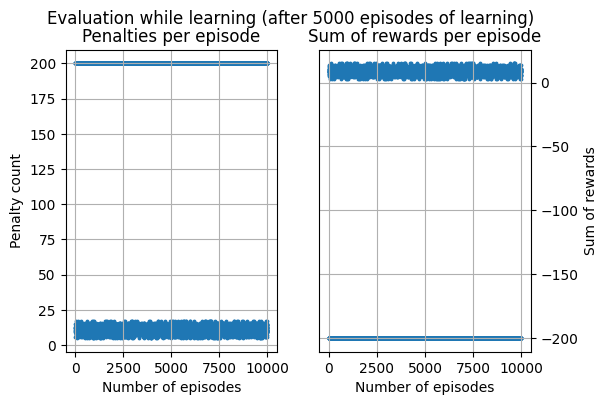

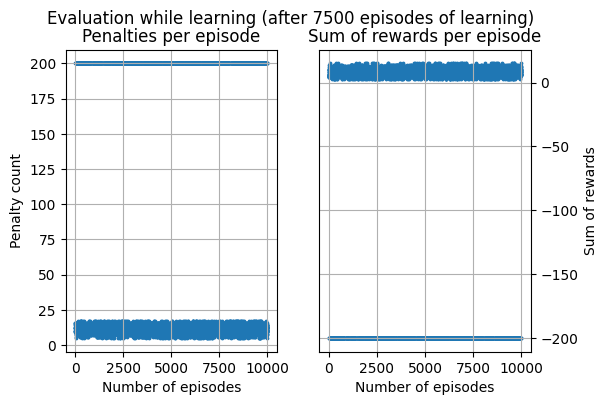

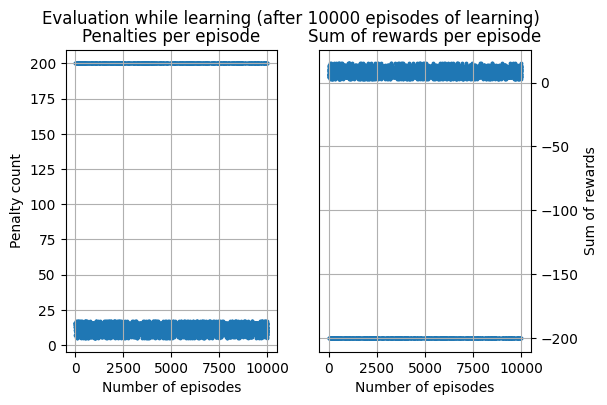

In [47]:
experiment(learning_rate=0.1, discount_factor=0.6, epsilon=0.1, episodes=10000)

Wniosek: zmniejszenie hiperparametru `learning_rate` wpłynęło negatywnie (w małym stopniu) na uzyskane wyniki - przykładowo, po 10000 epizodach średnia ilość kar na epizod była większa niż dla `learning_rate=0.5`.

### Eksperyment 4 - zwiększenie hiperparametru `discount_factor`

W tym eksperymencie hiperparametr `discount_factor` został zwiększony z 0.6 do 0.9.

               Episode Average epochs per episode Average penalty per episode
0   After episode 2500                    13.0957                     12.0957
1   After episode 5000                    13.1437                     12.1437
2   After episode 7500                    13.0663                     12.0663
3  After episode 10000                    13.1067                     12.1067


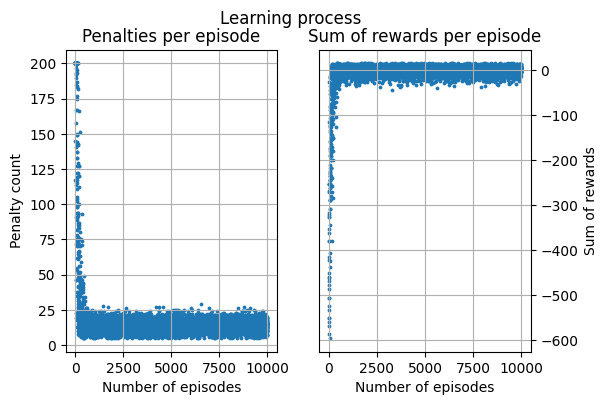

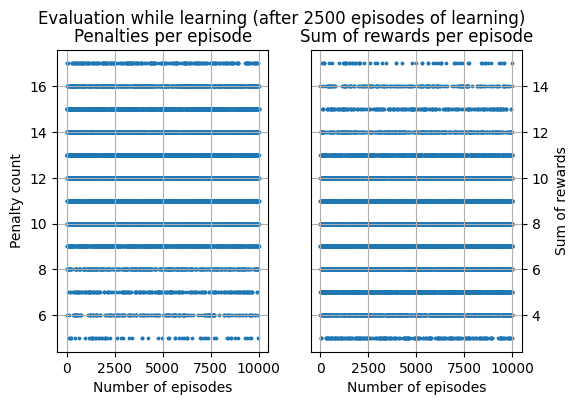

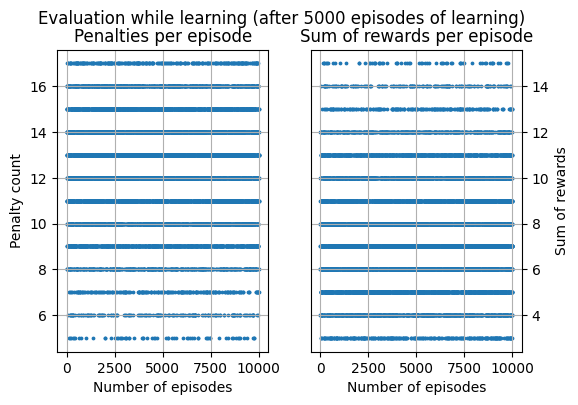

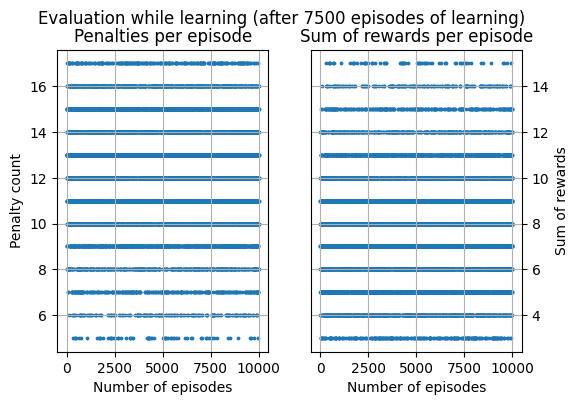

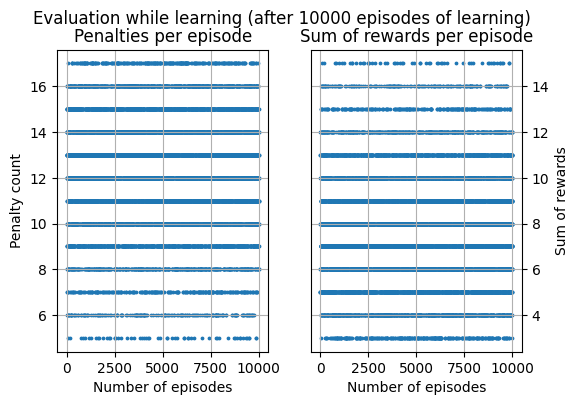

In [50]:
experiment(learning_rate=0.5, discount_factor=0.9, epsilon=0.1, episodes=10000)

Zwiększenie parametru `discount_factor` nie wpłynęło w znaczący sposób na wyniki.

### Eksperyment 5 - zmniejszenie parametru `discount_factor`

W tym eksperymencie hiperparametr `discount_factor` został zmniejszony z 0.6 do 0.1.

               Episode Average epochs per episode Average penalty per episode
0   After episode 2500                    35.0131                     34.1316
1   After episode 5000                    15.4793                     14.4921
2   After episode 7500                    13.0416                     12.0416
3  After episode 10000                    13.0607                     12.0607


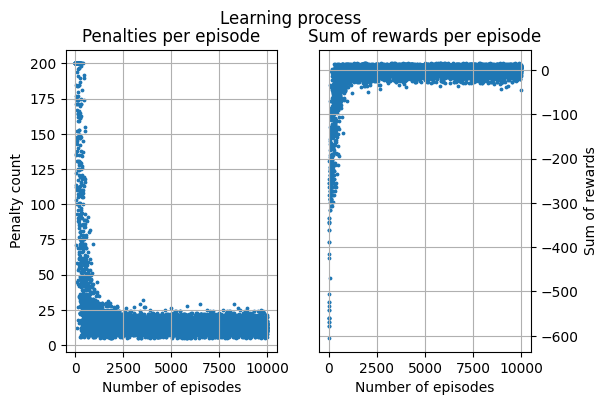

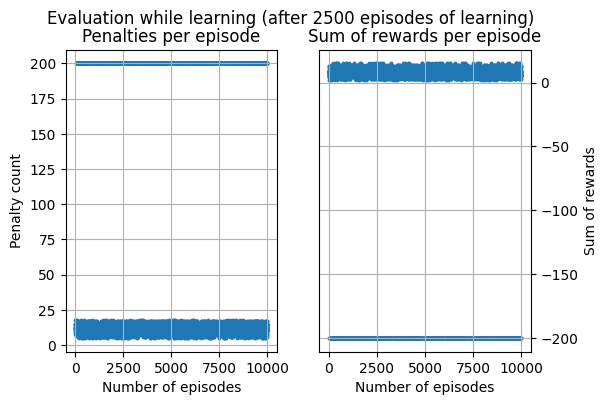

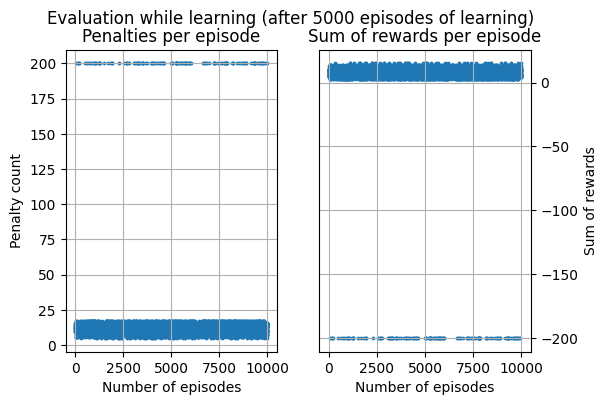

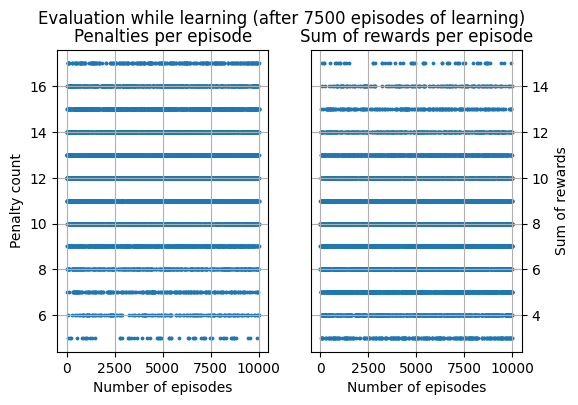

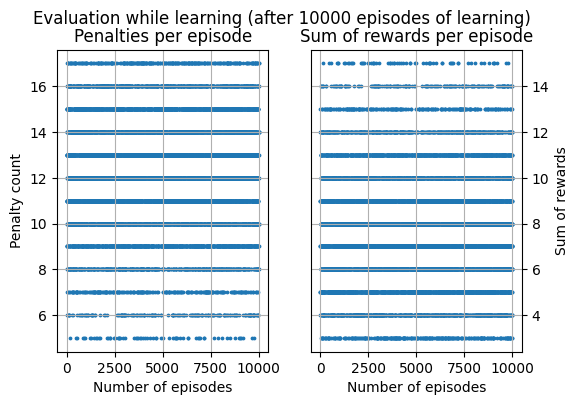

In [51]:
experiment(learning_rate=0.5, discount_factor=0.1, epsilon=0.1, episodes=10000)

Wniosek: zmniejszenie hiperparametru `discount_factor` nie wpłynęło na jakość modelu.

### Eksperyment 6 - zwiększenie hiperparametru `epsilon`

W tym eksperymencie hiperparametr `epsilon` został zwiększony z 0.1 do 0.9.

               Episode Average epochs per episode Average penalty per episode
0   After episode 2500                     13.073                      12.073
1   After episode 5000                    13.0653                     12.0653
2   After episode 7500                    13.0333                     12.0333
3  After episode 10000                    13.0847                     12.0847


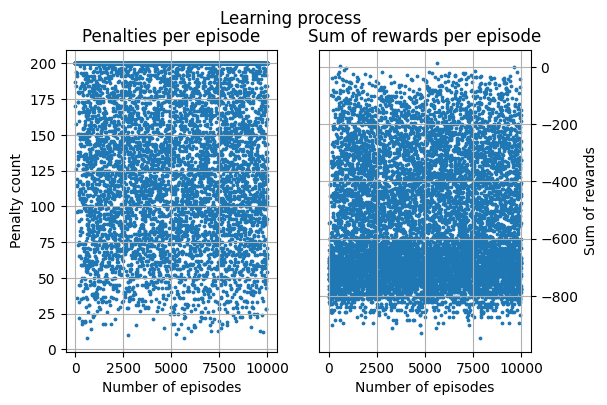

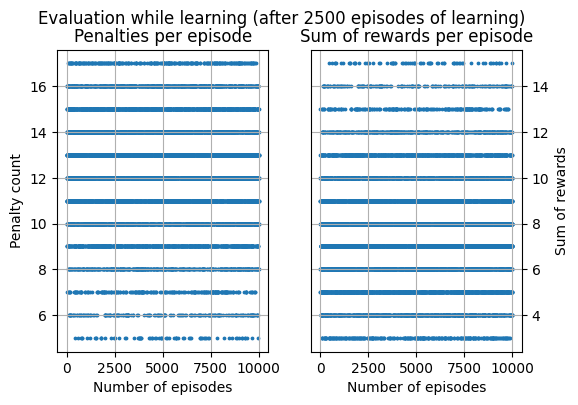

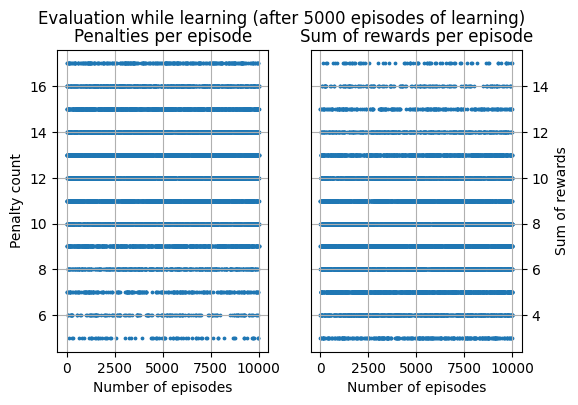

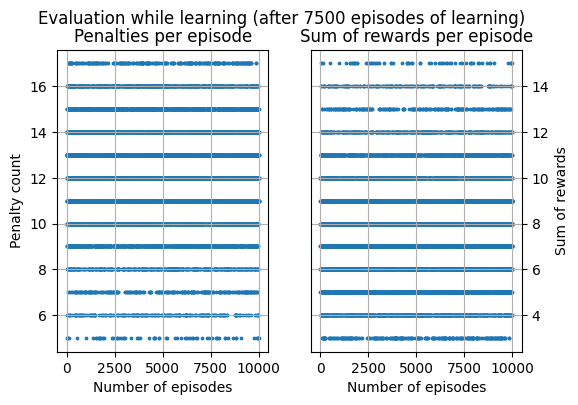

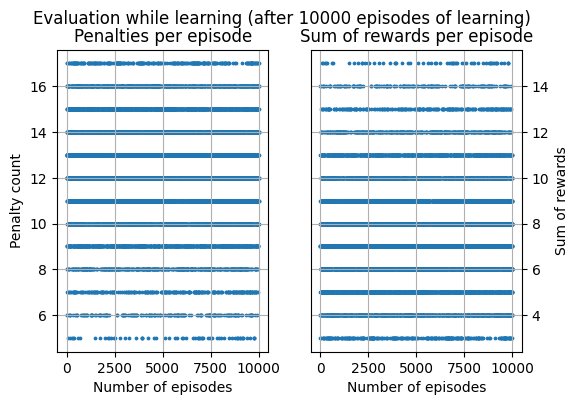

In [53]:
experiment(learning_rate=0.5, discount_factor=0.6, epsilon=0.9, episodes=10000)

Wniosek: zwiększenie parametru `epsilon` wpłynęło (w małym stopniu) negatywni na uzyskane wyniki.

### Eksperyment 6 - zmniejszenie parametru `epsilon`

W tym eksperymencie hiperparametr `epsilon` został zmniejszony z 0.1 do 0.01.

               Episode Average epochs per episode Average penalty per episode
0   After episode 2500                    18.4398                     17.4691
1   After episode 5000                    13.6683                     12.6716
2   After episode 7500                    13.8412                     12.8456
3  After episode 10000                    13.0126                     12.0126


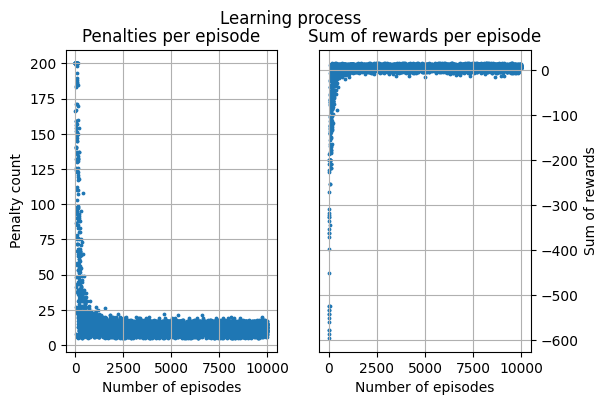

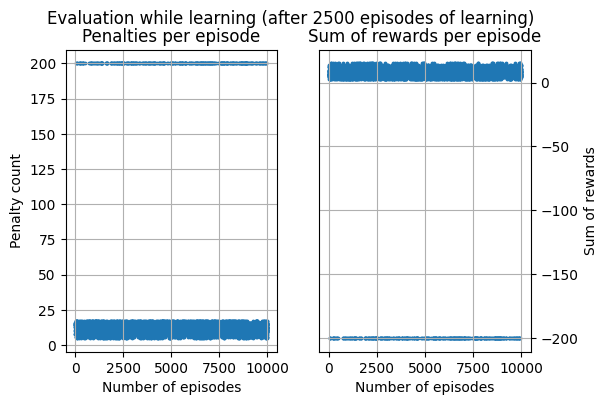

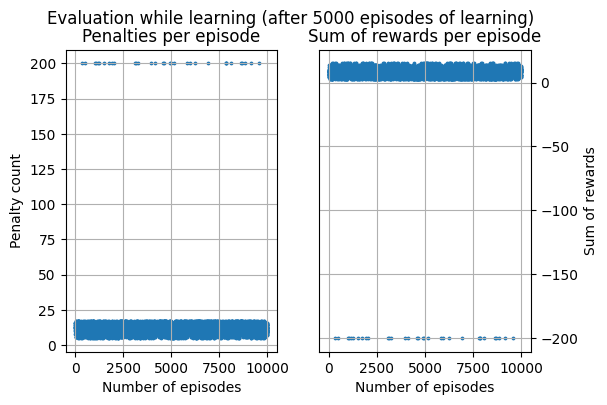

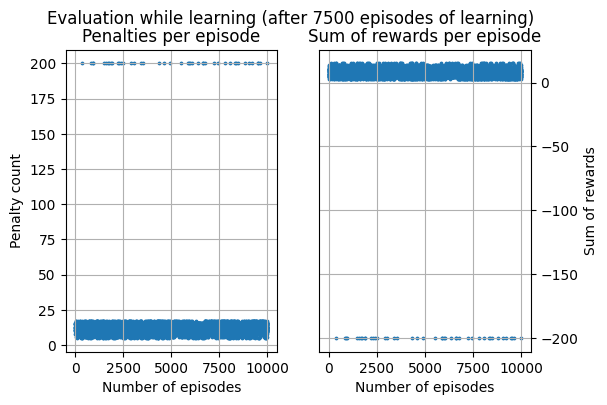

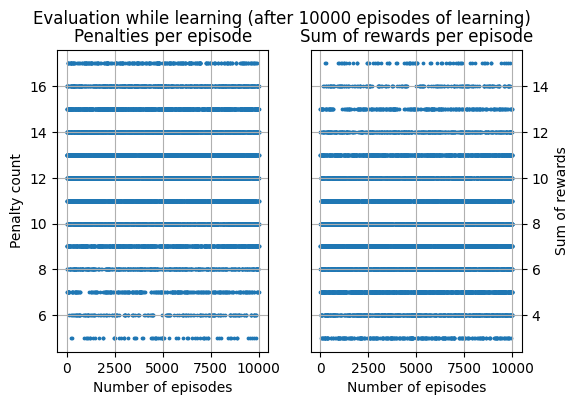

In [54]:
experiment(learning_rate=0.5, discount_factor=0.6, epsilon=0.01, episodes=10000)

Wniosek: zmniejszenie hiperparametru `epsilon` wpłynęło (w małym stopniu) pozytywnie na prędkość uczenia.

### Podsumowanie

Hiperparametrem mającym największy wpływ na jakość modelu jest `learning_rate`. Zbyt duża jego wartość prowadziła do braku jakiegokolwiek uczenia, natomiast zbyt mała źle wpływała na jego tempo.